In [17]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor, LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
np.set_printoptions(precision=2)
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', 100) # Increase the number of columns available so they don't get cut off on the screen
pd.options.display.max_colwidth=100

In [18]:
# p_d_sales joins transaction records and customer demographics into one table
p_d_sales = pd.read_csv('trans_demographic.csv', quotechar='"', index_col='BASKET_ID', dtype= {'DAY': int, 'SALES_VALUE': np.float64, 'TRANS_TIME': int, 'WEEK_NO':int,'COUPON_DISC':int, 'SUM(QUANTITY)': int,'AGE_DESC':str,'MARITAL_STATUS_CODE': str,'INCOME_DESC':str, 'HOMEOWNER_DESC':str, 'HH_COMP_DESC':str,  'HOUSEHOLD_SIZE_DESC':str, 'KID_CATEGORY_DESC':str})
demo = pd.read_table('demographics.csv', delimiter=',')  # Customer demographics only
demo = demo.drop('household_key', axis=1)  # Household key not needed
agg_no_gas = pd.read_table('agg_no_gas.csv', delimiter=',')  # Trasaction list- grocery items only

# Basic Exploration

### # Look at the structure of the data

In [19]:
p_d_sales[:5]

,DAY,SALES_VALUE,TRANS_TIME,WEEK_NO,COUPON_DISC,SUM(QUANTITY),AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
BASKET_ID,,,,,,,,,,,,,
1364,1,11.37,1520,1,0,5,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
1130,1,2.55,1340,1,0,9,55-64,U,25-34K,Renter,2 Adults Kids,3,1
98,1,5.79,1937,1,0,8,35-44,U,35-49K,Unknown,1 Adult Kids,2,1
1172,1,44.78,946,1,0,19,25-34,B,50-74K,Unknown,Single Male,1,None/Unknown
1060,1,139.22,1251,1,0,57,35-44,B,35-49K,Renter,2 Adults No Kids,2,None/Unknown


### # Compute summary statistics for transactions and demographics

In [20]:
agg_no_gas.describe(include='all')

,household_key,BASKET_ID,COUPON_DISC,sales,total,TRANS_TIME,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,KID_CATEGORY_DESC
count,68374.000000,6.837400e+04,68374.000000,68374.000000,68374.000000,68374.00000,68374,68374,68374,68374,68374
unique,NaN,NaN,NaN,NaN,NaN,NaN,6,3,12,5,4
top,NaN,NaN,NaN,NaN,NaN,NaN,45-54,U,50-74K,Homeowner,None/Unknown
freq,NaN,NaN,NaN,NaN,NaN,NaN,25479,30619,16100,40752,47631
mean,1236.779448,3.705888e+10,-0.014099,29.323511,13.877088,1549.91760,NaN,NaN,NaN,NaN,NaN
std,724.175541,3.795617e+09,0.234018,35.691412,16.965954,413.50583,NaN,NaN,NaN,NaN,NaN
min,1.000000,3.204082e+10,-30.000000,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,NaN
25%,622.000000,3.341275e+10,0.000000,6.000000,3.000000,1253.00000,NaN,NaN,NaN,NaN,NaN
50%,1228.000000,3.559822e+10,0.000000,16.110000,7.000000,1612.00000,NaN,NaN,NaN,NaN,NaN
75%,1879.000000,4.090014e+10,0.000000,38.460000,18.000000,1842.00000,NaN,NaN,NaN,NaN,NaN


In [21]:
demo.describe(include='all').T

,count,unique,top,freq
AGE_DESC,801,6,45-54,288
MARITAL_STATUS_CODE,801,3,U,344
INCOME_DESC,801,12,50-74K,192
HOMEOWNER_DESC,801,5,Homeowner,504
HH_COMP_DESC,801,6,2 Adults No Kids,255
HOUSEHOLD_SIZE_DESC,801,5,2,318
KID_CATEGORY_DESC,801,4,None/Unknown,558


In [22]:
p_d_sales.describe(include='all')

,DAY,SALES_VALUE,TRANS_TIME,WEEK_NO,COUPON_DISC,SUM(QUANTITY),AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
count,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339,140339,140339,140339,140339,140339,140339
unique,NaN,NaN,NaN,NaN,NaN,NaN,6,3,12,5,6,5,4
top,NaN,NaN,NaN,NaN,NaN,NaN,45-54,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
freq,NaN,NaN,NaN,NaN,NaN,NaN,51394,62822,32224,84814,43221,53845,97444
mean,393.636608,32.048940,1540.402461,56.934017,-0.010724,1168.151326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,185.936698,38.308015,416.637177,26.563007,0.196030,3836.425744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,0.000000,0.000000,1.000000,-30.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,236.000000,7.950000,1245.000000,34.000000,0.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,400.000000,19.750000,1604.000000,58.000000,0.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,553.000000,40.210000,1841.000000,80.000000,0.000000,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Drop unused columns
p_d_sales = p_d_sales.drop('DAY', axis=1)
p_d_sales = p_d_sales.drop('WEEK_NO', axis=1)
p_d_sales = p_d_sales.drop('TRANS_TIME', axis=1)
p_d_sales = p_d_sales.drop('SUM(QUANTITY)', axis=1)
p_d_sales = p_d_sales.drop('COUPON_DISC', axis=1)

### # Does it look like you think it should?

In [25]:
p_d_sales[:5]

,SALES_VALUE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
BASKET_ID,,,,,,,,
1364,11.37,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
1130,2.55,55-64,U,25-34K,Renter,2 Adults Kids,3,1
98,5.79,35-44,U,35-49K,Unknown,1 Adult Kids,2,1
1172,44.78,25-34,B,50-74K,Unknown,Single Male,1,None/Unknown
1060,139.22,35-44,B,35-49K,Renter,2 Adults No Kids,2,None/Unknown


In [26]:
p_d_sales.columns

Index([u'SALES_VALUE', u'AGE_DESC', u'MARITAL_STATUS_CODE', u'INCOME_DESC',
       u'HOMEOWNER_DESC', u'HH_COMP_DESC', u'HOUSEHOLD_SIZE_DESC',
       u'KID_CATEGORY_DESC'],
      dtype='object')

# Visualize Customer Demographics

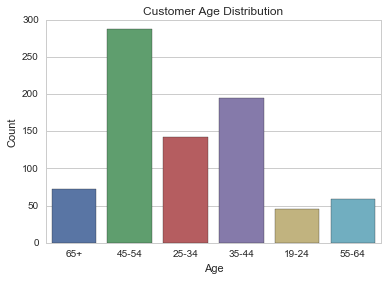

In [27]:
a = sns.countplot(x="AGE_DESC", data=demo)
sns.axlabel("Age", "Count")
a.axes.set_title('Customer Age Distribution')
plt.savefig('age.png')

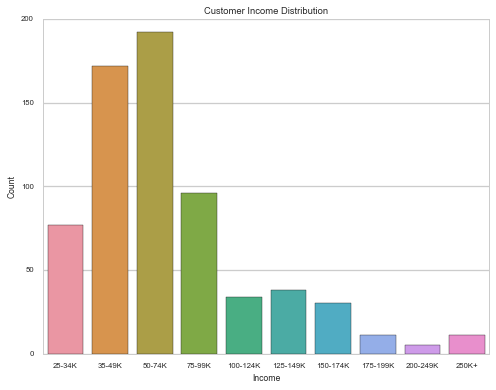

In [32]:
sns.set_context("talk", font_scale = 0.6)
plt.figure(figsize=(8, 6))
a = sns.countplot(x="INCOME_DESC", data=demo, order=['25-34K', '35-49K','50-74K', '75-99K', '100-124K', '125-149K', '150-174K', '175-199K', '200-249K', '250K+'])
sns.axlabel("Income", "Count")
a.axes.set_title('Customer Income Distribution')
plt.savefig('income.png')

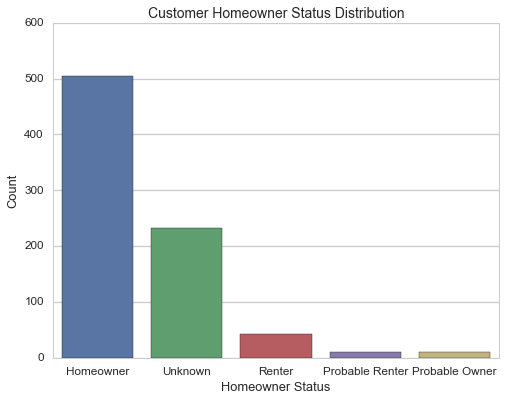

In [29]:
sns.set_context("talk", font_scale = 0.9)
plt.figure(figsize=(8, 6))
a = sns.countplot(x="HOMEOWNER_DESC", data=demo)
sns.axlabel("Homeowner Status", "Count")
a.axes.set_title('Customer Homeowner Status Distribution')
plt.savefig('homeowner.png')

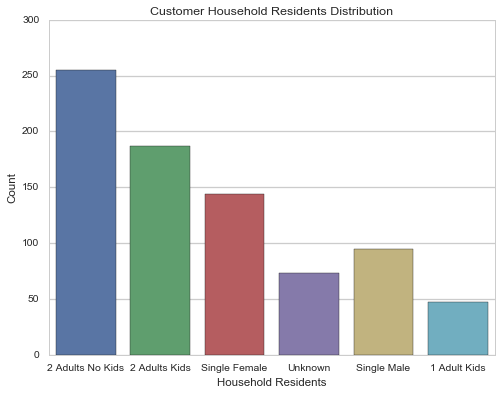

In [7]:
sns.set_context("talk", font_scale = 0.8)
plt.figure(figsize=(8, 6))
a = sns.countplot(x="HH_COMP_DESC", data=demo)
sns.axlabel("Household Residents", "Count")
a.axes.set_title('Customer Household Residents Distribution')
plt.savefig('residents.png')

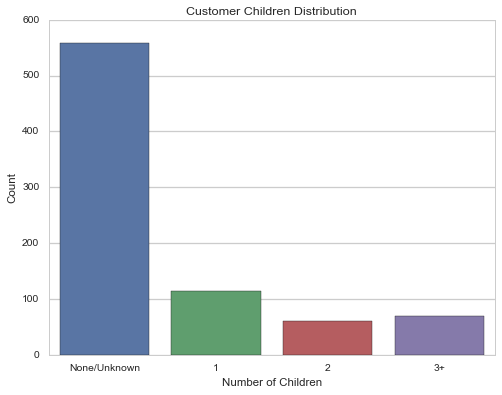

In [13]:
sns.set_context("talk", font_scale = 0.8)
plt.figure(figsize=(8, 6))
a = sns.countplot(x="KID_CATEGORY_DESC", data=demo)
sns.axlabel("Number of Children", "Count")
a.axes.set_title('Customer Children Distribution')
plt.savefig('kids.png')

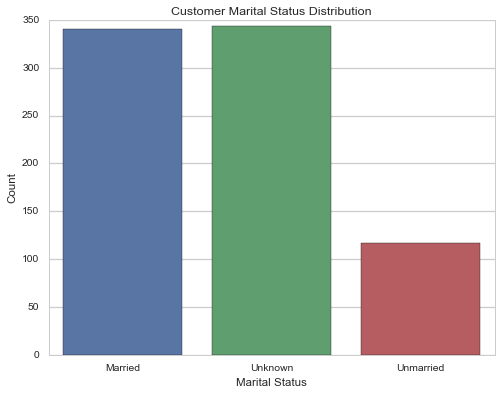

In [15]:
sns.set_context("talk", font_scale = 0.8)
plt.figure(figsize=(8, 6))
a = sns.countplot(x="MARITAL_STATUS_CODE", data=demo)
sns.axlabel("Marital Status", "Count")
a.axes.set_title('Customer Marital Status Distribution')
a.axes.set_xticklabels(['Married', 'Unknown','Unmarried'])
plt.savefig('marital.png')

# Visualize Transaction Data

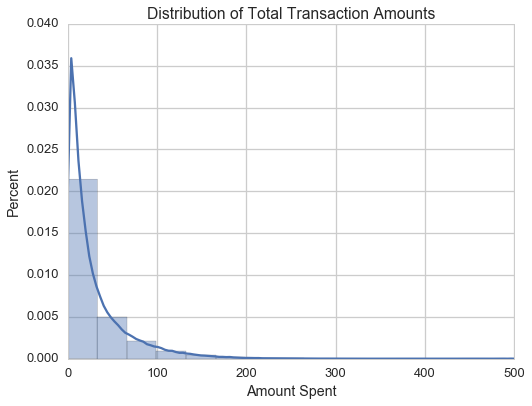

In [46]:
sns.set_context("talk")
plt.figure(figsize=(8, 6))
a = sns.distplot(agg_no_gas['sales'], bins = 15)
sns.axlabel("Amount Spent", "Percent")
plt.xlim(0, 500)
a.axes.set_title('Distribution of Total Transaction Amounts')
plt.savefig('total_amount_dist.png')

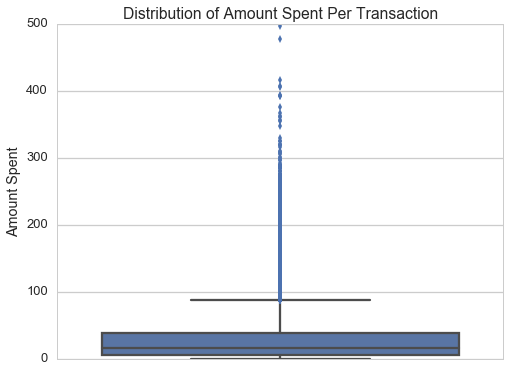

In [40]:
sns.set_context("talk")
plt.figure(figsize=(8, 6))
a = sns.boxplot(agg_no_gas['sales'], orient='v')
sns.axlabel("", "Amount Spent")
a.axes.set_title('Distribution of Amount Spent Per Transaction')
plt.savefig('amount_boxplot.png')

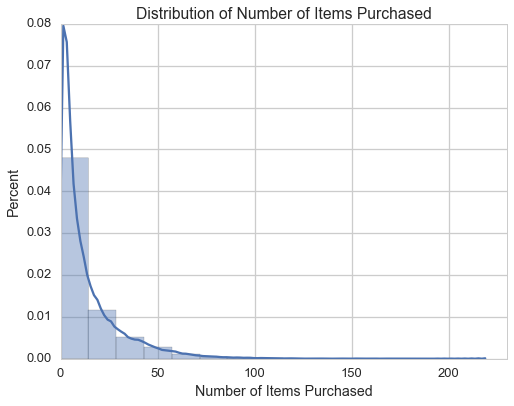

In [45]:
sns.set_context("talk")
plt.figure(figsize=(8, 6))
a = sns.distplot(agg_no_gas['total'], bins = 15)
sns.axlabel("Number of Items Purchased", "Percent")
plt.xlim(0, 230)
a.axes.set_title('Distribution of Number of Items Purchased')
plt.savefig('num_items_dist.png')

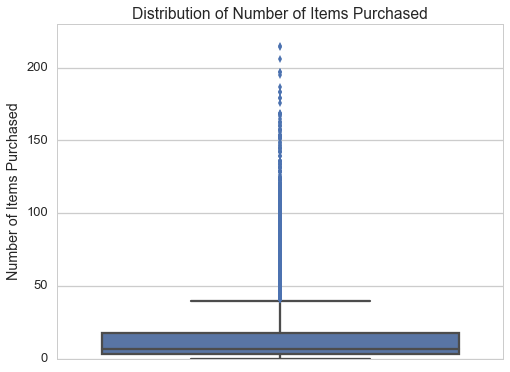

In [51]:
sns.set_context("talk")
plt.figure(figsize=(8, 6))
a = sns.boxplot(agg_no_gas['total'], orient='v')
sns.axlabel("", "Number of Items Purchased")
a.axes.set_title('Distribution of Number of Items Purchased')
plt.ylim(0, 230)
plt.savefig('quantity_boxplot.png')